In [6]:
import pandas as pd
import glob
import pathlib
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from kneed import KneeLocator
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import numpy as np
from matplotlib import pyplot as plt

### 取得特徵資料
- level 包含
  - IPsrc
  - IPdst
  - IPsrc/24
  - IPsrc/16
  - IPsrc/8
  - IPdst/24
  - IPdst/16
  - IPdst/8
  - traffic per time slot
- feature 包含
  - #pkts
  - #bytes
  - #syn

In [2]:
# IPsrc
# IPdst
# IPsrc/24
# IPsrc/16
# IPsrc/8
# IPdst/24
# IPdst/16
# IPdst/8
# traffic per time slot

# Load all the files in the folder
# for filename in glob.glob("data/*"):
#     df = pd.read_csv(filename, index_col=0)
#     df = df[["sa", "da", "flg", "ipkt", "opkt", "ibyt", "obyt"]]
#     df[["sa_8", "sa_16", "sa_24", "sa_32"]] = df["sa"].str.split(".", expand=True)
#     df[["da_8", "da_16", "da_24", "da_32"]] = df["da"].str.split(".", expand=True)
#     df["pkt"] = df["ipkt"] + df["opkt"]
#     df["byt"] = df["ibyt"] + df["obyt"]
    
#     # IPsrc
#     df_grouped = df.groupby(['sa'])
#     features = df_grouped[["pkt", "byt"]].sum()
#     features["syn"] = df_grouped["flg"].agg(lambda x: x.str.contains("S").sum())
#     pathlib.Path("hunting_data/IPsrc").mkdir(parents=True, exist_ok=True)
#     features.to_csv(os.path.join("hunting_data", filename.replace("data", "IPsrc")))
    
#     # IPdst
#     df_grouped = df.groupby(['da'])
#     features = df_grouped[["pkt", "byt"]].sum()
#     features["syn"] = df_grouped["flg"].agg(lambda x: x.str.contains("S").sum())
#     pathlib.Path("hunting_data/IPdst").mkdir(parents=True, exist_ok=True)
#     features.to_csv(os.path.join("hunting_data", filename.replace("data", "IPdst")))
    
#     # IPsrc/24
#     df_grouped = df.groupby(['sa_8', 'sa_16', 'sa_24'])
#     features = df_grouped[["pkt", "byt"]].sum()
#     features["syn"] = df_grouped["flg"].agg(lambda x: x.str.contains("S").sum())
#     pathlib.Path("hunting_data/IPsrc_24").mkdir(parents=True, exist_ok=True)
#     features.to_csv(os.path.join("hunting_data", filename.replace("data", "IPsrc_24")))
    
#     #IPsrc/16
#     df_grouped = df.groupby(['sa_8', 'sa_16'])
#     features = df_grouped[["pkt", "byt"]].sum()
#     features["syn"] = df_grouped["flg"].agg(lambda x: x.str.contains("S").sum())
#     pathlib.Path("hunting_data/IPsrc_16").mkdir(parents=True, exist_ok=True)
#     features.to_csv(os.path.join("hunting_data", filename.replace("data", "IPsrc_16")))
    
#     #IPsrc/8
#     df_grouped = df.groupby(['sa_8'])
#     features = df_grouped[["pkt", "byt"]].sum()
#     features["syn"] = df_grouped["flg"].agg(lambda x: x.str.contains("S").sum())
#     pathlib.Path("hunting_data/IPsrc_8").mkdir(parents=True, exist_ok=True)
#     features.to_csv(os.path.join("hunting_data", filename.replace("data", "IPsrc_8")))
    
#     #IPdst/24
#     df_grouped = df.groupby(['da_8', 'da_16', 'da_24'])
#     features = df_grouped[["pkt", "byt"]].sum()
#     features["syn"] = df_grouped["flg"].agg(lambda x: x.str.contains("S").sum())
#     pathlib.Path("hunting_data/IPdst_24").mkdir(parents=True, exist_ok=True)
#     features.to_csv(os.path.join("hunting_data", filename.replace("data", "IPdst_24")))
    
#     #IPdst/16
#     df_grouped = df.groupby(['da_8', 'da_16'])
#     features = df_grouped[["pkt", "byt"]].sum()
#     features["syn"] = df_grouped["flg"].agg(lambda x: x.str.contains("S").sum())
#     pathlib.Path("hunting_data/IPdst_16").mkdir(parents=True, exist_ok=True)
#     features.to_csv(os.path.join("hunting_data", filename.replace("data", "IPdst_16")))
    
#     #IPdst/8
#     df_grouped = df.groupby(['da_8'])
#     features = df_grouped[["pkt", "byt"]].sum()
#     features["syn"] = df_grouped["flg"].agg(lambda x: x.str.contains("S").sum())
#     pathlib.Path("hunting_data/IPdst_8").mkdir(parents=True, exist_ok=True)
#     features.to_csv(os.path.join("hunting_data", filename.replace("data", "IPdst_8")))
    
#     # traffic_id
#     df_grouped = df.groupby(['sa', 'da'])
#     features = df_grouped[["pkt", "byt"]].sum()
#     features["syn"] = df_grouped["flg"].agg(lambda x: x.str.contains("S").sum())
#     pathlib.Path("hunting_data/traffic_id").mkdir(parents=True, exist_ok=True)
#     features.to_csv(os.path.join("hunting_data", filename.replace("data", "traffic_id")))

In [ ]:
for dirname in ["IPsrc", "IPsrc_8", "IPsrc_16", "IPsrc_24", "IPdst_8", "IPdst_16", "IPdst_24"]:
    pathlib.Path(f"hunting_data/labelled_{dirname}").mkdir(parents=True, exist_ok=True)
    with open(f"hunting_data/labelled_{dirname}/log.txt", "w") as f:
        for filename in glob.glob(f"hunting_data/{dirname}/*"):
            df = pd.read_csv(filename, index_col=0)
            f.write("\n----------------------------------------------------\n")
            f.write(f"Filename: {filename}\n")
            index = 0
            for feature in [["pkt", "byt"], ["byt", "syn"], ["pkt", "syn"]]:
                index += 1
                f.write(f"\tfeature index: {index}\n")
                f.write(f"\tdeature: {feature}\n")
                sample = df[feature]
                k = sample.columns.size
                f.write(f"\tk: {k}\n")

                nbrs = NearestNeighbors(n_neighbors=k).fit(sample)
                distances, indices = nbrs.kneighbors(sample)
                distance_desc = sorted(distances[:, k - 1], reverse=True)
                kneedle = KneeLocator(range(1, len(distance_desc)+1),  # x values
                                    distance_desc,  # y values
                                    S=1.0,  # parameter suggested from paper
                                    curve="convex",  # parameter from figure
                                    direction="decreasing")  # parameter from figure
                f.write(f"\tknee_y: {kneedle.knee_y}\n")
                
                clusters = DBSCAN(eps=kneedle.knee_y, min_samples=k).fit(sample)
                df[f"label_{index}"] = clusters.labels_
            
            df.to_csv(filename.replace(dirname, f"labelled_{dirname}"))

In [3]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [73]:
df = pd.read_csv("hunting_data/labelled_IPsrc/20210103_00_00.csv")
df.set_index("sa", inplace=True)
df = df[["label_1", "label_2", "label_3"]]

In [89]:
df.value_counts()

label_1  label_2  label_3
 0        0        0         12711
                  -1            15
                   4            12
-1       -1       -1            10
 6        6        8             9
 0        0        6             7
 5        5        0             5
 3        3        0             5
 0        0        2             5
                   5             5
                   14            4
                   12            3
                   9             3
                   7             2
 4        4       -1             2
 0        0        11            2
                   15            2
                   3             2
-1       -1        9             2
 3        3        5             1
 7        7       -1             1
 6        6        13            1
-1       -1        1             1
 6        6        0             1
                  -1             1
 5        5        16            1
-1       -1        4             1
 5        5       -1         

In [74]:
def intersection(a, b):
    return (a == b).sum() / a.size

In [75]:
similarity_matrix = df.T.corr(method=intersection)

In [85]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model.fit(similarity_matrix)

AgglomerativeClustering()

In [86]:
np.unique(model.labels_, return_counts=True)

(array([0, 1], dtype=int64), array([12775,    57], dtype=int64))

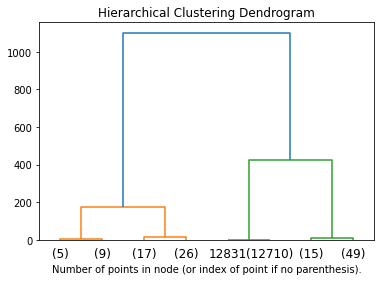

In [79]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=2)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
import math
int(
    (1 / math.sqrt(5)) *
    (
        (((1 + math.sqrt(5)) / 2)**(n + 1)) -
        (((1 - math.sqrt(5)) / 2)**(n + 1))
    )
)
